In [9]:
!pip install -q split-folders matplotlib scikit-learn

In [12]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
import splitfolders
import copy

In [3]:

input_folder = '/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset' 

split_output_folder = '/kaggle/working/dataset_split'

print(f"Membagi dataset dari '{input_folder}'...")

if os.path.exists(split_output_folder):
    os.system(f'rm -rf {split_output_folder}')
    
splitfolders.ratio(input_folder, output=split_output_folder, seed=42, ratio=(.8, .2))
print("Pembagian dataset selesai.")

Membagi dataset dari '/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset'...


Copying files: 885 files [00:14, 59.05 files/s] 

Pembagian dataset selesai.


In [4]:
# --- Konfigurasi Training ---
DATA_DIR = '/kaggle/working/dataset_split'
MODEL_SAVE_PATH = '/kaggle/working/cnn_tea_disease_classifier.pth'
CLASS_NAMES_SAVE_PATH = '/kaggle/working/class_names.txt'
NUM_EPOCHS = 25
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.01
IMAGE_SIZE = 224

# --- Transformasi Data ---
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'val'), transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = train_dataset.classes
num_classes = len(class_names)

print("DataLoader dan transformasi siap.")
print(f"Jumlah kelas terdeteksi: {num_classes} -> {class_names}")

DataLoader dan transformasi siap.
Jumlah kelas terdeteksi: 8 -> ['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


In [5]:
# --- Inisialisasi Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

# --- Inisialisasi Model (ResNet50) ---
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Dropout(p=0.6), nn.Linear(num_ftrs, num_classes))
model = model.to(device)

# --- Inisialisasi Komponen Training ---
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

print("Model, optimizer, dan loss function siap.")

Menggunakan device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s] 


Model, optimizer, dan loss function siap.


In [6]:
# Training Loop
print("\n--- MEMULAI TRAINING MODEL ---")

history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

best_accuracy = 0.0
patience = 5
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    # --- Tahap Training ---
    model.train()
    total_train_loss = 0
    train_correct, train_total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        
        total_train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total

    # --- Tahap Validasi ---
    model.eval()
    val_correct, val_total, total_val_loss = 0, 0, 0 
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    avg_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_acc'].append(train_accuracy)
    history['val_acc'].append(val_accuracy)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"    -> Akurasi validasi meningkat, model disimpan.")
        patience_counter = 0  
    else:
        patience_counter += 1 
        print(f"    -> Akurasi tidak meningkat. Patience: {patience_counter}/{patience}")


    if patience_counter >= patience:
        print(f"\n--- Early stopping di epoch {epoch+1} karena tidak ada peningkatan. ---")
        break



--- MEMULAI TRAINING MODEL ---
Epoch [1/25], Train Loss: 1.9718, Train Acc: 31.16%, Val Loss: 1.7809, Val Acc: 56.98%
    -> Akurasi validasi meningkat, model disimpan.
Epoch [2/25], Train Loss: 1.5580, Train Acc: 59.07%, Val Loss: 1.2218, Val Acc: 69.27%
    -> Akurasi validasi meningkat, model disimpan.
Epoch [3/25], Train Loss: 1.1189, Train Acc: 72.95%, Val Loss: 0.9860, Val Acc: 75.42%
    -> Akurasi validasi meningkat, model disimpan.
Epoch [4/25], Train Loss: 0.9432, Train Acc: 80.59%, Val Loss: 0.8731, Val Acc: 78.77%
    -> Akurasi validasi meningkat, model disimpan.
Epoch [5/25], Train Loss: 0.8046, Train Acc: 84.28%, Val Loss: 0.7923, Val Acc: 83.80%
    -> Akurasi validasi meningkat, model disimpan.
Epoch [6/25], Train Loss: 0.7554, Train Acc: 90.79%, Val Loss: 0.7910, Val Acc: 81.56%
    -> Akurasi tidak meningkat. Patience: 1/5
Epoch [7/25], Train Loss: 0.7408, Train Acc: 91.64%, Val Loss: 0.8002, Val Acc: 83.80%
    -> Akurasi tidak meningkat. Patience: 2/5
Epoch [8/25]

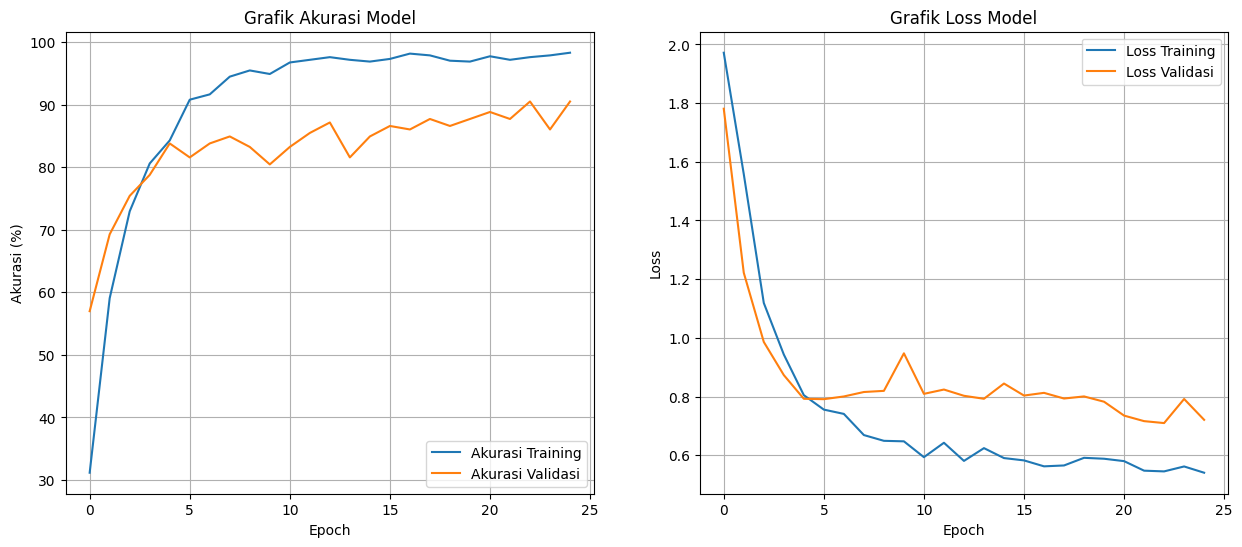


--- Membuat prediksi pada data validasi untuk Laporan Klasifikasi ---

Laporan Klasifikasi Detail:
               precision    recall  f1-score   support

  Anthracnose       0.77      0.85      0.81        20
   algal leaf       1.00      0.91      0.95        23
bird eye spot       0.86      0.95      0.90        20
 brown blight       0.95      0.83      0.88        23
   gray light       0.94      0.80      0.86        20
      healthy       1.00      0.93      0.97        15
red leaf spot       0.97      1.00      0.98        29
   white spot       0.82      0.93      0.87        29

     accuracy                           0.91       179
    macro avg       0.91      0.90      0.90       179
 weighted avg       0.91      0.91      0.91       179

--------------------------------------------------


In [13]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1); plt.plot(history['train_acc'], label='Akurasi Training'); plt.plot(history['val_acc'], label='Akurasi Validasi')
plt.title('Grafik Akurasi Model'); plt.xlabel('Epoch'); plt.ylabel('Akurasi (%)'); plt.legend(); plt.grid(True)
plt.subplot(1, 2, 2); plt.plot(history['train_loss'], label='Loss Training'); plt.plot(history['val_loss'], label='Loss Validasi')
plt.title('Grafik Loss Model'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.show()

print("\n--- Membuat prediksi pada data validasi untuk Laporan Klasifikasi ---")
model.load_state_dict(torch.load(MODEL_SAVE_PATH)); model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images); _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy()); y_pred.extend(predicted.cpu().numpy())
print("\nLaporan Klasifikasi Detail:"); print(classification_report(y_true, y_pred, target_names=class_names)); print("-" * 50)

In [14]:
with open(CLASS_NAMES_SAVE_PATH, 'w') as f:
    for item in class_names:
        f.write("%s\n" % item)

print(f"Model disimpan di: {MODEL_SAVE_PATH}")
print(f"Nama kelas disimpan di: {CLASS_NAMES_SAVE_PATH}")
print("\nAnda sekarang bisa mengunduh kedua file tersebut dari panel 'Data' di sebelah kanan, di bawah direktori 'Output/kaggle/working'.")

Model disimpan di: /kaggle/working/cnn_tea_disease_classifier.pth
Nama kelas disimpan di: /kaggle/working/class_names.txt

Anda sekarang bisa mengunduh kedua file tersebut dari panel 'Data' di sebelah kanan, di bawah direktori 'Output/kaggle/working'.
